# Laboratorio di Simulazione Numerica: lezione 7

Elia Steve, 47122A

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

In [2]:
import sys
import subprocess
import os
sys.path.append("..")
from lib_NSL_py.simulator import run_simulation, set_properties, remove_output, set_config_file

In [3]:
nsl_sim_path = "../NSL_SIMULATOR"

In [4]:
#Compiles the simulator in case it isn't already compiled
subprocess.run(["make", "-C", nsl_sim_path + "/SOURCE"])

make: Nothing to be done for `all'.


CompletedProcess(args=['make', '-C', '../NSL_SIMULATOR/SOURCE'], returncode=0)

### Esercizi 7.1, 7.2

In questi esercizi dobbiamo modidficare il codice del simulatore per aggiungere il calcolo delle correzioni di coda per l'energia potenziale e per la pressione: successivamente dobbiamo usare i valori dell'energia potenziale ottenuti via Monte Carlo per calcolare la funzione di autocorrelazione, stimare quindi la larghezza dei blocchi da usare nelle simulazioni e fare un grafico dell'incertezza sul valore finale in funzione della larghezza del blocco per un sistema di Argon nelle fasi solida, liquida e gassosa.

#### Correzioni di coda per la pressione

La pressione si calcola con l'equazione

$$
P = \rho k_\mathrm{B}T + \frac{\langle W \rangle}{V}
$$

con $\rho$, $T$, $V$ densità, pressione e temperatura rispettivamente, e $W$ il viriale, che nei sistemi di Lennard-Jones è

$$
W = \frac{1}{3}\sum_{i\neq j} 48\epsilon \Bigg[\Big(\frac{\sigma}{r_{ij}}\Big)^{12} - \frac{1}{2}\Big(\frac{\sigma}{r_{ij}}\Big)^{6}\Bigg],
$$

con $\sigma$ ed $\epsilon$ i parametri che compaiono nel potenziale di Lennard-Jones e $r_{ij}$ la distanza fra la particella $i$ e la particella $j$.

In generale la correzione di coda per una grandezza a due corpi

$$
A(\textbf{r}_1, \textbf{r}_2, \dots, \textbf{r}_N) = \frac{1}{2}\sum_{i\neq j} a(r_{ij})
$$

in un fluido omogeneo è data da

$$
\langle A \rangle _{\mathrm{tail}} = 2\pi\rho N \int_{r_\mathrm{cut}}^\infty a(r)r^2dr :
$$

il viriale si scrive come

$$
W(\textbf{r}_1, \textbf{r}_2, \dots, \textbf{r}_N) = \frac{1}{2}\sum_{i\neq j} w(r_{ij})
$$

con 

$$
w(r) = \frac{96}{3}\epsilon \bigg[\Big(\frac{\sigma}{r}\Big)^{12} - \frac{1}{2}\Big(\frac{\sigma}{r}\Big)^{6}\bigg].
$$

La correzione di coda al viriale è dunque

$$
\begin{split}
\langle W \rangle _{\mathrm{tail}} & = 2\pi\rho N \int_{r_\mathrm{cut}}^\infty \frac{96\epsilon}{3}\bigg[\Big(\frac{\sigma}{r}\Big)^{12} - \frac{1}{2}\Big(\frac{\sigma}{r}\Big)^{6}\bigg] r^2dr \\
&= 64\pi\rho N\epsilon\sigma^3 \bigg[\frac{1}{9}\Big(\frac{\sigma}{r_\mathrm{cut}}\Big)^{9} - \frac{1}{6}\Big(\frac{\sigma}{r_\mathrm{cut}}\Big)^{3}\bigg],
\end{split}
$$

o in unità di Lennard-Jones

$$
\langle W \rangle _{\mathrm{tail}}  = 64\pi\rho N \bigg[\frac{1}{9 r_\mathrm{cut}^9} - \frac{1}{6 r_\mathrm{cut}^3}\bigg].
$$

La correzione di coda alla pressione dunque vale

$$
P_{\mathrm{tail}} = \frac{\langle W \rangle _{\mathrm{tail}}}{V} = 64\pi\rho^2 \bigg[\frac{1}{9 r_\mathrm{cut}^9} - \frac{1}{6 r_\mathrm{cut}^3}\bigg].
$$

Comincio definendo alcune variabili utili e preparando l'input del simulatore:

In [5]:
starting_parameters = [
    {"T":0.8, "rho":1.1, "r_cut":2.2, "name":"solid", "it_name":"Solido"},
    {"T":1.1, "rho":0.8, "r_cut":2.5, "name":"liquid", "it_name":"Liquido"},
    {"T":1.2, "rho":0.05, "r_cut":5.0, "name":"gas", "it_name":"Gas"}
]

In [6]:
remove_output(nsl_sim_path)
set_properties(nsl_sim_path, ["potential_energy"])
set_config_file(nsl_sim_path, "lj")

rm: ../NSL_SIMULATOR/OUTPUT/*.*: No such file or directory
rm: ../NSL_SIMULATOR/OUTPUT/CONFIG/*.*: No such file or directory


È buona regola fissare la probabilità di accettazione per la simulazione Montecarlo a circa il 50% aggiustando la larghezza della distribuzione di probabilità per la proposta delle mosse: definisco una funzione che determini questa larghezzza in modo che la probabilità di accettazione sia compresa fra il 50% e il 62%. Ho scelto la larghezza del 62% perché ho osservato che nel caso del gas, anche aumentando la larghezza della distribuzione a molte volte il lato della scatola, la probabilità di accettazione si attestava intorno al 61%. Ipotizzo che questo sia dovuto a una variabilità ridotta del peso di Boltzmann $e^{-\beta H}$ all'interno della cella di simulazione.

In [7]:
def fix_acceptance(nsl_sim_path, parameters):
    delta = 0.05
    while True:
        run_simulation(
            folder = nsl_sim_path,
            temperature = parameters["T"],
            density = parameters["rho"],
            r_cut = parameters["r_cut"],
            n_steps = 1,
            n_blocks = 5000,
            n_eqsteps = 0,
            tail = 1,
            sim_type = 1,
            delta=delta
        )
        acc = np.loadtxt(nsl_sim_path + "/OUTPUT/acceptance.dat", skiprows=5000, usecols=1)
        print("Finished sim with delta =", delta, "acc =", acc)
        #This value was cherry picked because in the case of the gas the acceptance remains about this large
        #without decreasing any further, even with gigantic values of delta
        if acc > 0.62: delta *= 1.1
        elif acc < 0.5: delta *= 0.9
        else: return delta

Eseguo le simulazioni:

In [8]:
for parameters in starting_parameters:
    output_file = "potential_energy_" + str(parameters["T"]) + ".dat"
    if not os.path.isfile(output_file):
        print("Running sim with T =", parameters["T"])
        delta_file = "delta_" + str(parameters["T"]) + ".dat"
        if os.path.isfile(delta_file):
            with open(delta_file) as f: delta = float(f.read())
        else:
            delta = fix_acceptance(nsl_sim_path, parameters)
            with open(delta_file, "w") as f:
                f.write(str(delta))
        run_simulation(
                folder = nsl_sim_path,
                temperature = parameters["T"],
                density = parameters["rho"],
                r_cut = parameters["r_cut"],
                n_steps = 1,
                n_blocks = 50000,
                n_eqsteps = 5000,
                tail = 1,
                sim_type=1,
                delta = delta
            )
        subprocess.run(["mv", nsl_sim_path + "/OUTPUT/potential_energy.dat", output_file])
        subprocess.run(["mv", nsl_sim_path + "/OUTPUT/acceptance.dat", "acceptance_" + str(parameters["T"]) + ".dat"])

Ora definisco funzioni utili per calcolare la funzione di autocorrelazione ed eseguire un fit con un esponenziale:

In [9]:
def unnorm_chi(t, a):
  t_upper = len(a)-t
  a1 = a[:t_upper]
  a2 = a[t:]
  return np.dot(a1, a2)/t_upper - np.mean(a1)*np.mean(a2)

vectorized_unnorm_chi = np.vectorize(unnorm_chi, signature="(),(n)->()")

In [10]:
def f(t, tau): return np.exp(-t/tau)
ts = np.arange(1000)
Ls = np.int32(np.geomspace(10, 5000, 300))

Calcolo le funzioni di autocorrelazione, eseguo il fit con l'esponenziale e calcolo l'incertezza nel valore finale in funzione della lunghezza dei blocchi:

Solido
tau = 8.799297976993186 ± 0.08591490761040475


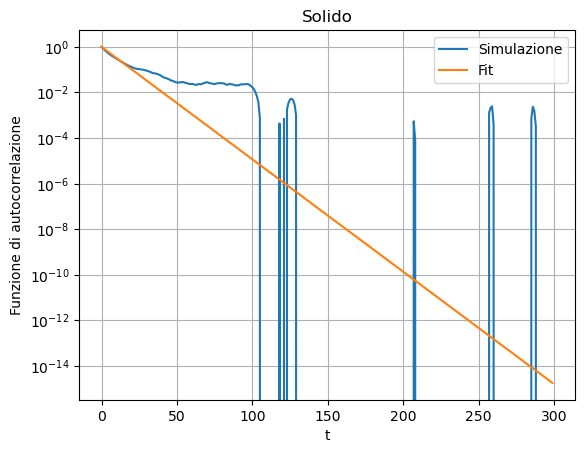

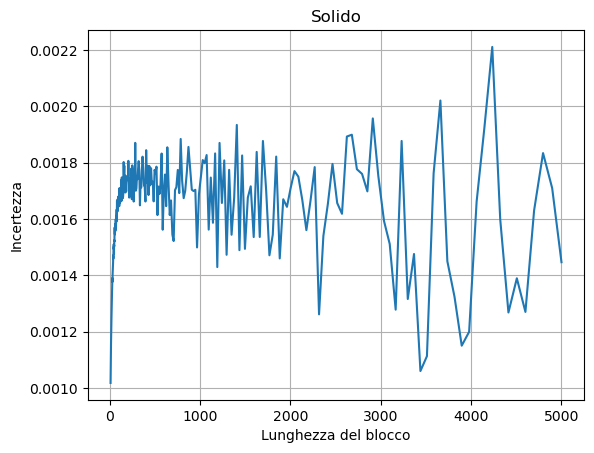

Liquido
tau = 10.372499727701763 ± 0.1868835444459331


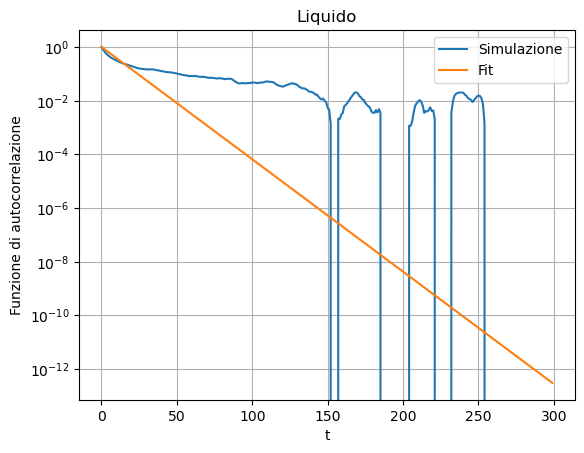

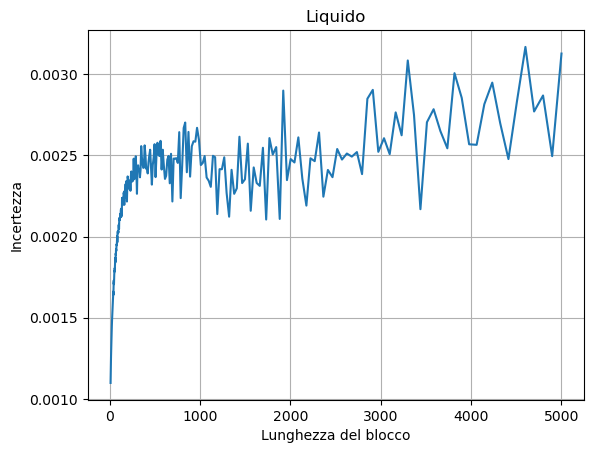

Gas
tau = 2.1655203979244866 ± 0.021566155263020633


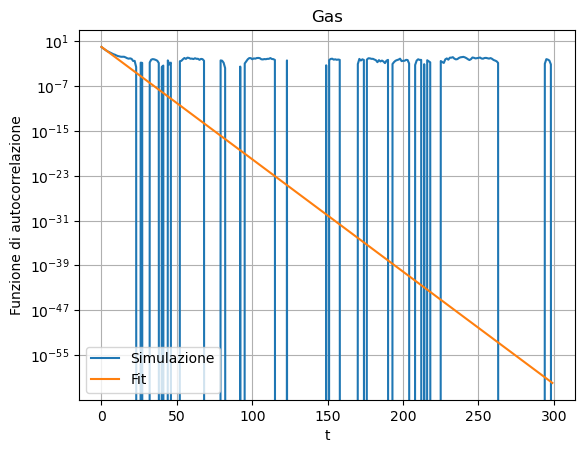

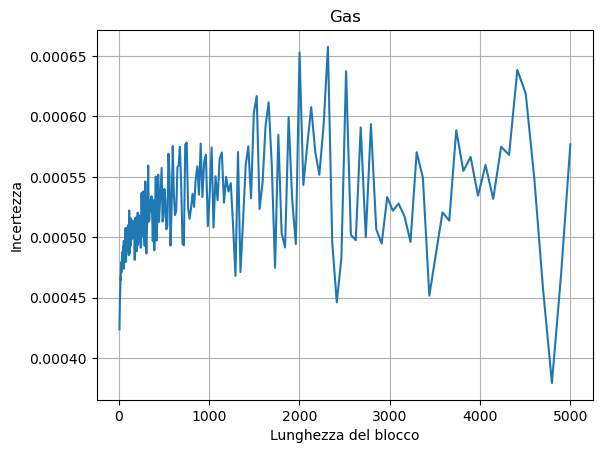

In [11]:
for parameters in starting_parameters:
    print(20*"=")
    print(parameters["it_name"])
    print(20*"=")
    #Read values, compute cross-coerrelation and fit to an exponential
    aves = np.loadtxt("potential_energy_" + str(parameters["T"]) + ".dat", usecols=1)
    chis = vectorized_unnorm_chi(ts, aves)/np.var(aves)
    popt, pcov = scipy.optimize.curve_fit(f, ts, chis)
    print("tau = " + str(popt[0]) + " ± " + str(np.sqrt(pcov[0][0])))

    #Plot cross-correlation and fit
    plt.plot(ts[:300], chis[:300], label="Simulazione")
    plt.plot(ts[:300], f(ts[:300], popt[0]), label="Fit")
    plt.yscale("log")
    plt.title(parameters["it_name"])
    plt.ylabel("Funzione di autocorrelazione")
    plt.xlabel("t")
    plt.legend()
    plt.grid()
    plt.show()

    #Plot errors as a function of block size
    vars = []
    for L in Ls:
        #Split the data in blocks of length L
        #In general the last block will be shorter than the other ones, throw it away
        blocks = np.array_split(aves, np.arange(L, 50000, step=L))[:-1]
        block_means = np.mean(blocks, axis=1)
        vars.append(np.std(block_means)/np.sqrt(np.shape(block_means)[0]))
    plt.plot(Ls, vars)
    plt.title(parameters["it_name"])
    plt.ylabel("Incertezza")
    plt.xlabel("Lunghezza del blocco")
    plt.grid()
    plt.show()

Per la funzione di autocorrelazione vediamo il comportamento che ci aspettiamo (dopo un certo numero di valori la funzione decade praticamente a zero, e il tratto iniziale è descritto relativamente bene da una funzione del tipo $\chi(t)=e^{-t/\tau}$). Per quanto riguarda l'incertezza nel valore finale, vediamo che per lunghezze dei blocchi piccole, per cui i dati in blocchi diversi sono correlati, l'incertezza è bassa: man mano che la lunghezza dei blocchi cresce l'incertezza aumanta, e si attesta a un valore costate a meno di fluttuazioni una volta che i blocchi diventano scorrelati. Usando le informazioni che ho estratto decido la lunghezza appropriata per i blocchi per simulazioni nelle varie fasi. La lunghezza del blocco nel caso del gas, in particolare, è molto più lunga di quella che servirebbe solamente per avere blocchi non correlati: ho usato questa scelta perché il gas nelle condizioni delle nostre simulazioni è fortemente oscillatorio, e quindi le proprietà misurate vanno mediate su tempi molto lunghi.

In [12]:
#Solido
starting_parameters[0]["block_size"] = 200
#Liquido
starting_parameters[1]["block_size"] = 250
#Gas
starting_parameters[2]["block_size"] = 5000

### Esercizi 7.3, 7.4

In questi esercizi dobbiamo implementare il calcolo della funzione di distribuzione radiale $g(r)$: successivamente dobbiamo calcolare pressione, energia potenziale per particella e $g(r)$ per un sistema di Argon nelle fasi solida, liquida e gassosa sia via Montecarlo sia via dinamica molecolare, e confrontare i risultati. Il mio codice scrive i valori della $g(r)$ per ogni blocco tranne l'ultimo su un file con il nome `gofr_blk<numero del blocco>.dat`, e il valore per l'ultimo blocco su uno con il nome di `gofr.dat`.

Prima di procedere al calcolo nel caso dell'Argon, per testare la mia implementazione calcolo la funzione di distribuzione radiale per un gas perfetto (ottenuto imponendo $r_\mathrm{cut} = 0$), per il quale $g(r)=1$ identicamente.

In [13]:
rs, gs, errors = np.loadtxt("ideal_gas/gofr.dat", unpack=True)

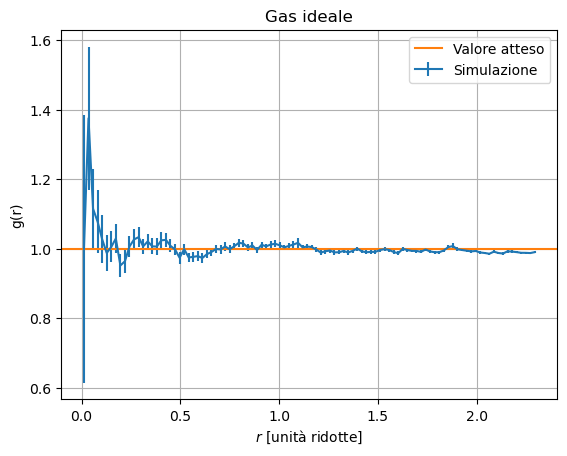

In [14]:
plt.errorbar(rs, gs, yerr=errors, label="Simulazione")
plt.axhline(1, color="tab:orange", label="Valore atteso")
plt.title("Gas ideale")
plt.xlabel(r"$r$ [unità ridotte]")
plt.ylabel(r"g(r)")
plt.legend()
plt.grid()

Vediamo che c'è buon accordo fra i valori calcolati e quelli attesi. Ora procedo con le simulazioni per l'Argon, misurando anche la temperatura. Nel caso della dinamica molecolare, uso le temperature di partenza che ho calcolato per l'esercitazione 4.

In [15]:
remove_output(nsl_sim_path)
set_properties(nsl_sim_path, ["potential_energy", "kinetic_energy", "temperature", "pressure", "gofr"], gofr_points=100)
set_config_file(nsl_sim_path, "lj")

rm: ../NSL_SIMULATOR/OUTPUT/*.*: No such file or directory
rm: ../NSL_SIMULATOR/OUTPUT/CONFIG/*.*: No such file or directory


In [16]:
for parameters in starting_parameters:
    output_dir = parameters["name"] + "_metro"
    if not os.path.isdir(output_dir):
        print("Running sim with T =", parameters["T"])
        with open("delta_" + str(parameters["T"]) + ".dat") as f:
            delta = float(f.read())
        run_simulation(
                folder = nsl_sim_path,
                temperature = parameters["T"],
                density = parameters["rho"],
                r_cut = parameters["r_cut"],
                n_steps = parameters["block_size"],
                n_blocks = 100,
                n_eqsteps = 5000,
                tail = 1,
                sim_type=1,
                delta = delta
            )
        subprocess.run(
            [
                "rsync",
                "-a",
                "--delete",
                nsl_sim_path + "/OUTPUT/",
                output_dir + "/"
            ]
        )

In [17]:
for parameters in starting_parameters:
    output_dir = parameters["name"] + "_md"
    if not os.path.isdir(output_dir):
        print("Running sim with T =", parameters["T"])
        with open("initial_temp_" + str(parameters["T"]) + ".dat") as f:
            parameters["T_start"] = float(f.readline().strip())
        run_simulation(
                folder = nsl_sim_path,
                temperature = parameters["T_start"],
                density = parameters["rho"],
                r_cut = parameters["r_cut"],
                n_steps = parameters["block_size"],
                n_blocks = 100,
                n_eqsteps = 5000,
                tail = 1,
                sim_type=0,
            )
        subprocess.run(
            [
                "rsync",
                "-a",
                "--delete",
                nsl_sim_path + "/OUTPUT/",
                output_dir + "/"
            ]
        )

Disegno i grafici:

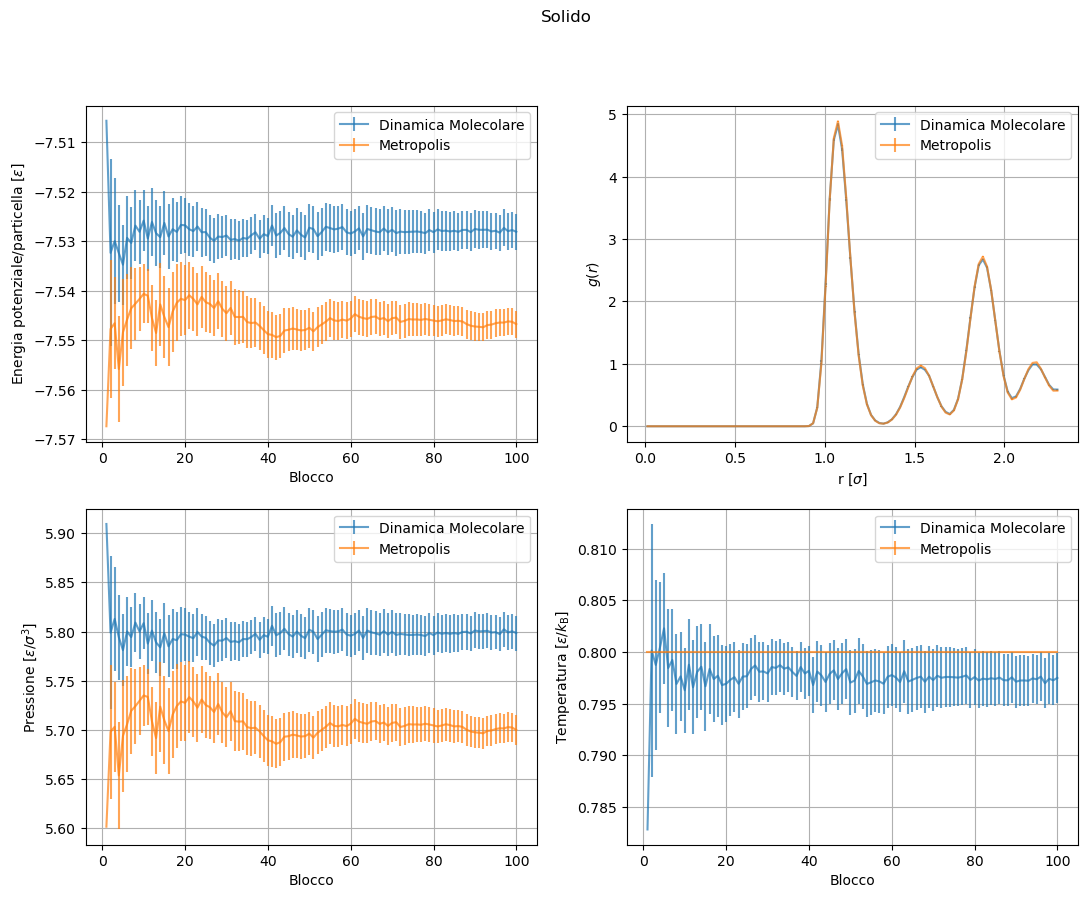

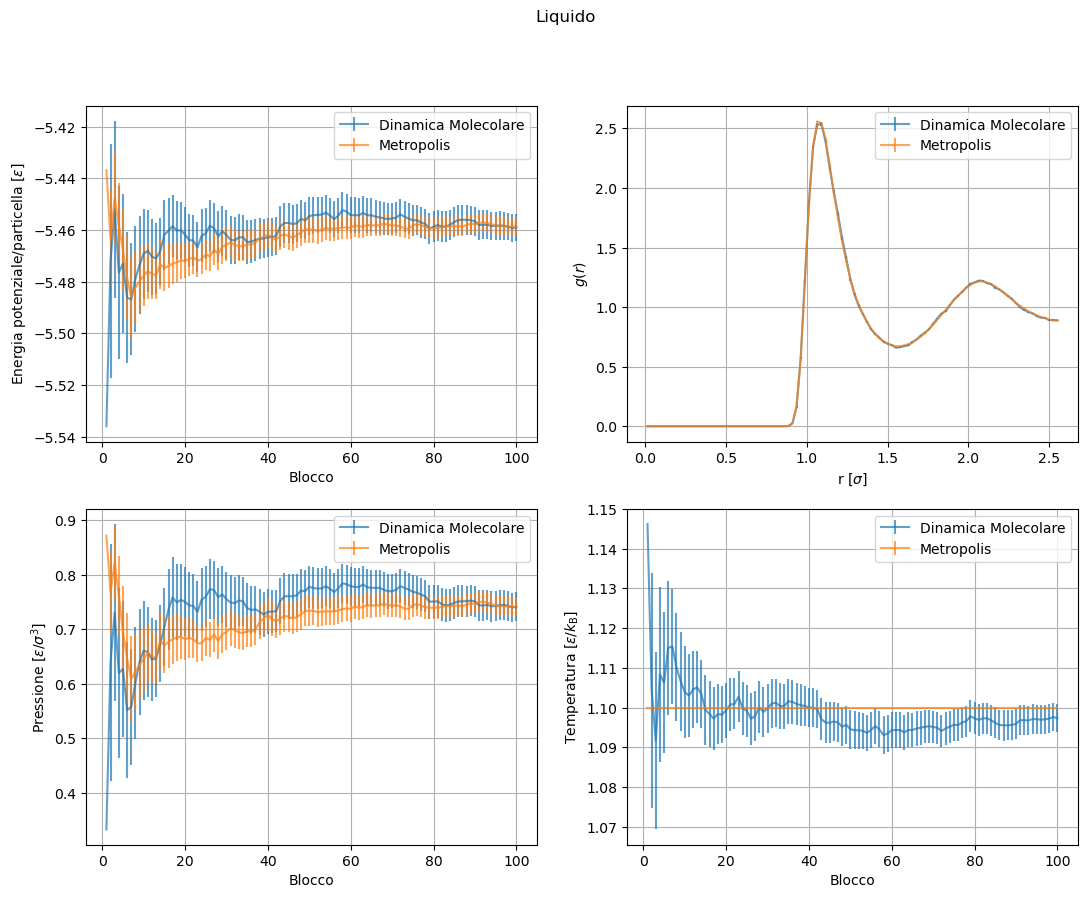

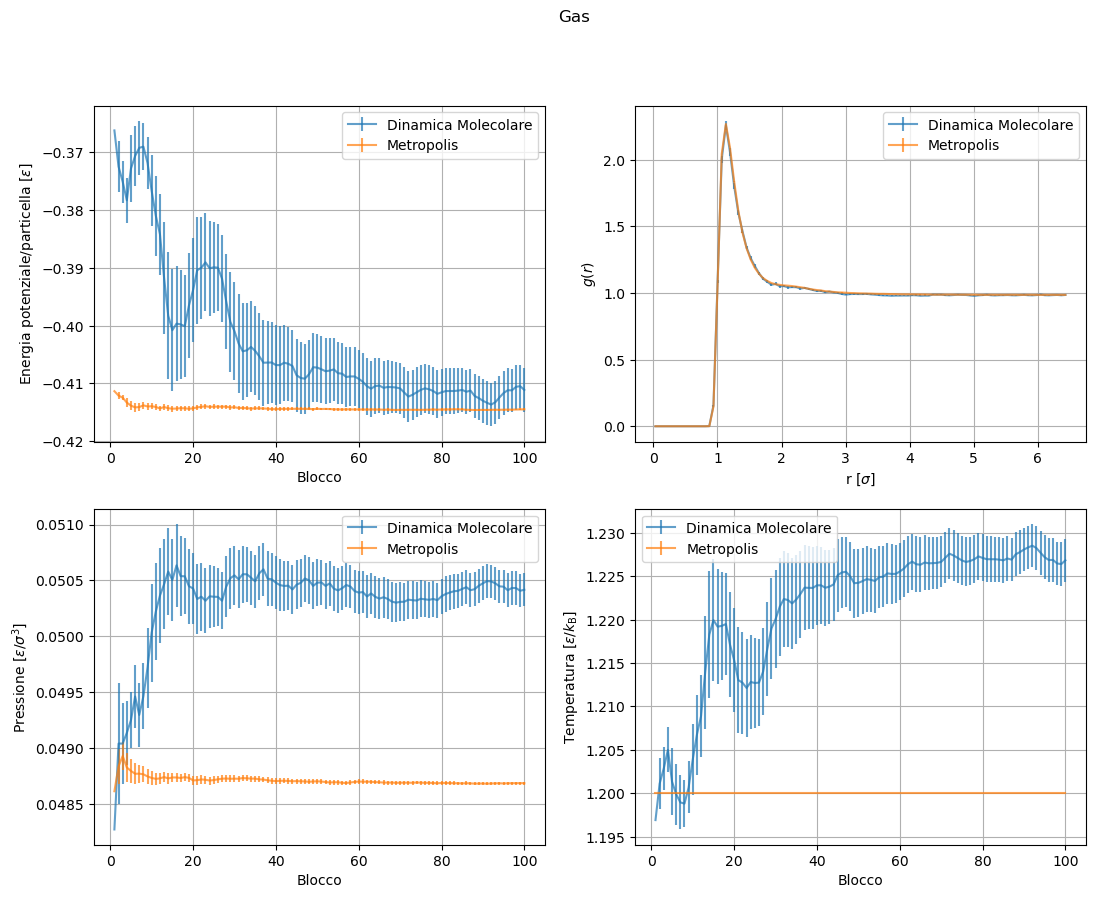

In [19]:
for parameters in starting_parameters:
    fig, ((ax_pot, ax_gofr), (ax_pressure, ax_temperature)) = plt.subplots(2, 2, figsize=(12.8, 9.6))
    fig.suptitle(parameters["it_name"])
    for property, ax, name in zip(
        ["pressure", "potential_energy", "temperature", "gofr"],
        [ax_pressure, ax_pot, ax_temperature, ax_gofr],
        [
            r"Pressione [$\epsilon/\sigma^3$]",
            r"Energia potenziale/particella [$\epsilon$]",
            r"Temperatura [$\epsilon/k_\mathrm{B}$]",
            r"$g(r)$"
        ]
    ):
        for mode, label in zip(["md", "metro"], ["Dinamica Molecolare", "Metropolis"]):
            if property == "gofr":
                xs, vals, errs = np.loadtxt(
                    parameters["name"] + "_" + mode + "/" + property + ".dat",
                    usecols=(0, 1, 2),
                    skiprows=1,
                    unpack=True
                )
                ax.set_xlabel("r [$\sigma$]")
                ax.set_ylabel(name)
            else:
                xs, vals, errs = np.loadtxt(
                    parameters["name"] + "_" + mode + "/" + property + ".dat",
                    usecols=(0, 2, 3),
                    skiprows=1,
                    unpack=True
                )
                ax.set_xlabel("Blocco")
                ax.set_ylabel(name)
            ax.errorbar(xs, vals, yerr=errs, label=label, alpha=0.7)

        ax.legend()
        ax.grid()

Osservazioni:

* la compatibilità fra i valori ottenuti tramite Metropolis e dinamica molecolare è discreta, e in particolare la compatibilità delle $g(r)$ è eccellente. L'unica eccezione è il caso del gas dove la compatibilità fra le pressioni è meno buona: questo fatto probabilmente è dovuto al fatto che i due sistemi si trovano a temperature leggermente diverse.
* La struttura delle varie $g(r)$ è quella che ci aspettiamo: in tutti i casi $g(r)=0$ per piccolo $r$, coerentemente con la presenza di un core repulsivo nel potenziale; nel caso di solido, liquido sono presenti diversi picchi, corrispondenti alla distanza degli $n$-esimi vicini; a grande distanza l'interazione si indebolice e $g(r)\simeq 1$ come nel gas ideale, effetto particolarmente evidente nel caso del gas.
* Le correzioni di coda diminuiscono il valore di energie potenziale per particella e pressione rispetto a quelli ottenuti nell'esercitazione 4, coerentemente con il fatto che per tutti i valori di $r_\mathrm{cut}$ energia potenziale e viriale sono negativi quando $r>r_\mathrm{cut}$.